In [2]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import pickle
import umap

# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('../report_plots/report.mplstyle')


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 10

In [3]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

def load_scd_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    scds = data['scd']  # (neurons, num_cov, steps)
    cov = data['covariates']  # (num_cov, steps)
    
    return scds, cov

def plot_pca(components, labels, label_names, plot3d=False, ax=None, colors=None, s=6, legendsize=6):
    
    sorted_indices = np.argsort(labels)
    sorted_components = components[sorted_indices]
    
    num_neurons_per_label = []
    for i, name in enumerate(label_names):
        num_neurons_per_label.append(np.where(labels==i)[0].size)
    cum_neurons = np.cumsum(np.array(num_neurons_per_label))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    if colors is None:
        colors = list(matplotlib.colors.BASE_COLORS)

    if ax is None:
        if plot3d:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
        else:
            _, ax = plt.subplots()
    if not plot3d:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=label, s=s,  alpha=1)
        ax.set_title('First 2 principal components of neuronal features')
    else:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], sorted_components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=label, s=s,  alpha=0.5)
        ax.set_title('First 3 principal components of neuronal features')
    #ax.legend(prop={'size': legendsize}, loc='upper right')
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    if plot3d:
        ax.set_zlabel('3rd PC')

import numba

@numba.njit()
def hellinger(x, y):
    result = 0.0
    l1_norm_x = 0.0
    l1_norm_y = 0.0

    for i in range(x.shape[0]):
        result += np.sqrt(x[i] * y[i])
        l1_norm_x += x[i]
        l1_norm_y += y[i]
        
    else:
        return np.sqrt(1 - result / np.sqrt(l1_norm_x * l1_norm_y))
    
@numba.njit()
def correlation_hellinger(x, y, steps, K):
    x = np.reshape(x, (steps, K))
    y = np.reshape(y, (steps, K))
    result = 0
    for i in range(x.shape[0]):
        result += hellinger(x[i], y[i])
    
    return result

In [4]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'
datadir_scd = '/scratches/ramanujan_2/vn283/HDC_PartIII/scd_data/'


phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = 120806
subset='hdc'
data, _, _ = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
steps = data.shape[2]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features_rates_tc = np.empty((0, steps))  # we have 6 covariates, so 6 features
features_FF_tc = np.empty((0, steps))

data, _ = load_scd_data(datadir_scd, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
count = data.shape[2]
steps = data.shape[1]
features = np.empty((0, steps, count))  # we have 6 covariates, so 6 features

correlation = []

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
            
            features_rates_tc = np.concatenate((features_rates_tc, tc_rates[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
            features_FF_tc = np.concatenate((features_FF_tc, tc_FF[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
            
            scds, covariates = load_scd_data(datadir_scd, mouse_id, session_id, subset)

            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = scds.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = scds.shape[0]
            
            # need to pad the distributions with 0 since they don't have the same max spike count
            diff = np.abs(features.shape[2] - scds.shape[2])
            if features.shape[2] < scds.shape[2]:
                features = np.pad(features, ((0,0),(0,0),(0,diff)), mode='constant', constant_values=0)
            else:
                scds = np.pad(scds, ((0,0),(0,0),(0,diff)), mode='constant', constant_values=0)
            features = np.concatenate((features, scds), axis=0) 

K = features.shape[2]
steps = features.shape[1]
neurons = features.shape[0]

features = np.reshape(features, (neurons, steps*K))
labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

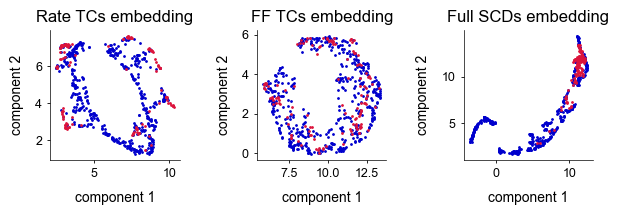

In [5]:
## more complex umap results

fig = plt.figure(figsize=(7,3))

s=1
colors = ['mediumblue', 'crimson']

gs = gridspec.GridSpec(1,3, fig, wspace=0.6, width_ratios=[1,1,1])


ax1 = fig.add_subplot(gs[0])
reducer = umap.UMAP(n_neighbors=20, min_dist=0.05 , n_components=3, metric='correlation')
embedding_rates = reducer.fit_transform(features_rates_tc)
plot_pca(embedding_rates, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=colors, ax=ax1, s=s)
ax1.set_title('Rate TCs embedding')
ax1.set_box_aspect(1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = fig.add_subplot(gs[1])
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1 , n_components=3, metric='correlation')
embedding_ff = reducer.fit_transform(features_FF_tc)
plot_pca(embedding_ff, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=colors, ax=ax2, s=s)
ax2.set_title('FF TCs embedding')
ax2.set_box_aspect(1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3 = fig.add_subplot(gs[2])
kwds = [steps, K]
mapping = umap.UMAP(n_neighbors=20, min_dist=0.1, n_components=3, metric=correlation_hellinger, metric_kwds={'steps':steps, 'K':K}).fit(features)
embedding = mapping.embedding_
plot_pca(embedding, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=colors, ax=ax3, s=s)
ax3.set_title('Full SCDs embedding')
ax3.set_box_aspect(1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

fig.savefig("/homes/vn283/UCM-interpret/figures/UMAP.pdf", format="pdf", bbox_inches="tight")

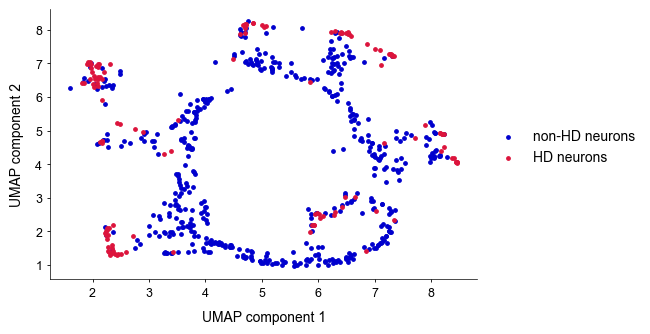

In [9]:
fig, ax = plt.subplots(figsize=(5.5,3.5))

colors = ['mediumblue', 'crimson']

reducer = umap.UMAP(n_neighbors=20, min_dist=0.05 , n_components=3, metric='correlation')
embedding_rates = reducer.fit_transform(features_rates_tc)
plot_pca(embedding_rates, np.array(labels_hdc), ['non-HD neurons', 'HD neurons', ], colors=colors, ax=ax, s=6)
ax.set_xlabel('UMAP component 1')
ax.set_ylabel('UMAP component 2')
ax.set_title('')
ax.legend(prop={'size': 10}, bbox_to_anchor = (1.4, 0.6))

plt.show()